In [11]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import numpy as np
import random
from collections import Counter
import os
import matplotlib.pyplot as plt
import importlib

# custom import
import dataset
import NNv2 as NN

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: " + str(device))

device: cuda


In [13]:
# parameters
vocab_size = 1024
embedding_dim = 16
n = 9
input_size = embedding_dim * (n-1)
hidden_size = 64

learning_rate = 1e-3
batch_size = 512

In [14]:
# model
importlib.reload(NN)

model = NN.FNN(vocab_size, input_size, embedding_dim, hidden_size).to(device)
print(model)

FNN(
  (embedding): Embedding(1024, 16)
  (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
  )
)


In [15]:
# prepare data
importlib.reload(dataset)

data = dataset.Dataset()
if os.path.exists("data_n_gram.pkl"):
    data.load("data_n_gram.pkl")
else:
    data.gen(vocab_size=vocab_size, n=n, batch_size=batch_size, filename='ChineseCorpus199801.txt', encoding="gbk", type="n_gram")
    data.save("data_n_gram.pkl")

top words: {'，/w': 1, '的/u': 2, '。/w': 3, '、/w': 4, '在/p': 5, '和/c': 6, '了/u': 7, '是/v': 8, '“/w': 9, '”/w': 10, '一/m': 11, '有/v': 12, '不/d': 13, '（/w': 14, '）/w': 15, '对/p': 16, '：/w': 17, '中/f': 18, '这/r': 19, '上/f': 20, '要/v': 21, '他/r': 22, '也/d': 23, '等/u': 24, '人/n': 25, '经济/n': 26, '；/w': 27, '个/q': 28, '说/v': 29, '为/p': 30, '年/q': 31, '中国/ns': 32, '到/v': 33, '企业/n': 34, '为/v': 35, '就/d': 36, '地/u': 37, '记者/n': 38, '新/a': 39, '工作/vn': 40, '大/a': 41, '从/p': 42, '我们/r': 43, '两/m': 44, '以/p': 45, '》/w': 46, '《/w': 47, '都/d': 48, '一个/m': 49, '我/r': 50, '１月/t': 51, '国家/n': 52, '问题/n': 53, '与/p': 54, '着/u': 55, '发展/vn': 56, '已/d': 57, '将/d': 58, '多/m': 59, '市场/n': 60, '发展/v': 61, '元/q': 62, '还/d': 63, '而/c': 64, '把/p': 65, '本报/r': 66, '能/v': 67, '后/f': 68, '人民/n': 69, '建设/vn': 70, '他们/r': 71, '并/c': 72, '向/p': 73, '使/v': 74, '进行/v': 75, '李/nr': 76, '全国/n': 77, '好/a': 78, '了/y': 79, '电/n': 80, '与/c': 81, '出/v': 82, '社会/n': 83, '但/c': 84, '我国/n': 85, '新华社/nt': 86, '时/Ng': 87, '由/p': 88,

In [16]:
# load model
if not os.path.exists("checkpoint"):
    os.mkdir("checkpoint")

pth_list = os.listdir("checkpoint")
latest_pth = None
cumulative_epoch = None
for pth in pth_list:
    if pth.endswith(".pth") and pth.startswith("FNN"):
        if latest_pth is None:
            latest_pth = pth
        else:
            id = int(pth.split("-")[-1].split(".")[0])
            latest_id = int(latest_pth.split("-")[-1].split(".")[0])
            if id > latest_id:
                latest_pth = pth
                cumulative_epoch = id

if latest_pth is not None:
    print("load model from checkpoint/" + latest_pth)
    model.load_state_dict(torch.load("checkpoint/" + latest_pth))
    model.eval()

In [17]:
# prepare trainer
if cumulative_epoch is None:
    cumulative_epoch = 0
x_record = []
y_record = []

trainer = NN.Trainer(learning_rate, model)

In [119]:
# train
epochs = 10
learning_rate = 1e-3
for t in range(epochs):
    print(f"Epoch {cumulative_epoch+1}\n-------------------------------")
    trainer.train(data.train_dataloader, learning_rate=learning_rate)
    correct, test_loss = trainer.test(data.test_dataloader)

    cumulative_epoch+=1
    x_record.append(cumulative_epoch)
    y_record.append((correct, test_loss, learning_rate))
    
    if cumulative_epoch % 5 == 0:
        if not os.path.exists('checkpoint'):
            os.makedirs('checkpoint')
        torch.save(trainer.model.state_dict(), './checkpoint/FNN-'+str(cumulative_epoch)+'.pth')
print("Done!")

Epoch 51
-------------------------------
loss: 3.462092  [51200/796108]
loss: 3.551478  [102400/796108]
loss: 3.282057  [153600/796108]
loss: 3.194469  [204800/796108]
loss: 3.358365  [256000/796108]
loss: 3.218843  [307200/796108]
loss: 3.440169  [358400/796108]
loss: 3.476769  [409600/796108]
loss: 3.630261  [460800/796108]
loss: 3.511471  [512000/796108]
loss: 3.485394  [563200/796108]
loss: 3.475013  [614400/796108]
loss: 3.235067  [665600/796108]
loss: 3.211059  [716800/796108]
loss: 3.661387  [768000/796108]
Test: 
 Accuracy: 39.0%, Avg loss: 3.455042 

Epoch 52
-------------------------------
loss: 3.438864  [51200/796108]
loss: 3.624487  [102400/796108]
loss: 3.426430  [153600/796108]
loss: 3.471729  [204800/796108]
loss: 3.479588  [256000/796108]
loss: 3.276624  [307200/796108]
loss: 3.393433  [358400/796108]
loss: 3.428288  [409600/796108]
loss: 3.678849  [460800/796108]
loss: 3.416182  [512000/796108]
loss: 3.261712  [563200/796108]
loss: 3.381867  [614400/796108]
loss: 3.42

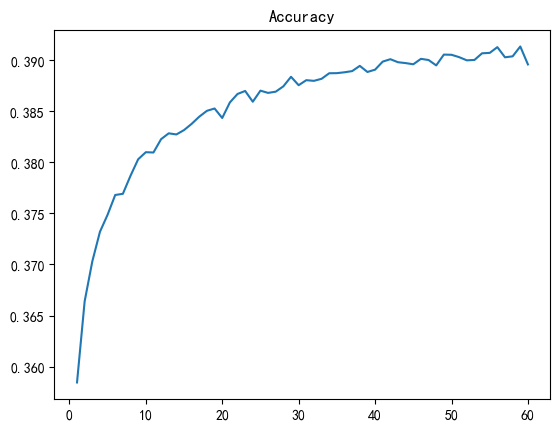

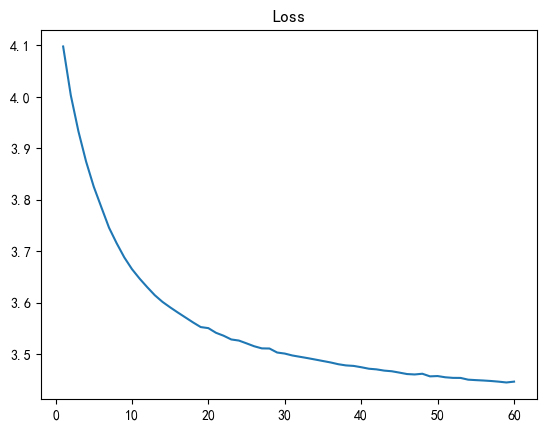

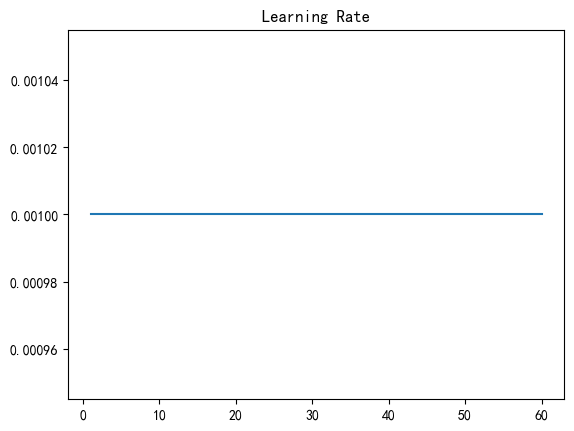

In [120]:
# plot the accuracy and loss curves
plt.plot(x_record, np.array(y_record)[:,0])
plt.title("Accuracy")
plt.show()
plt.plot(x_record, np.array(y_record)[:,1])
plt.title("Loss")
plt.show()
plt.plot(x_record, np.array(y_record)[:,2])
plt.title("Learning Rate")
plt.show()

In [144]:
def get_lookup_table(model):
    lookup_table = model.embedding.weight.data
    lookup_table = lookup_table.cpu().numpy()
    return lookup_table

lookup_table = get_lookup_table(trainer.model)
print(lookup_table.shape)

def top_10_similar(lookup_table, word_idx):
    word_vec = lookup_table[word_idx]
    similarity = np.dot(lookup_table, word_vec)/np.linalg.norm(lookup_table, axis=1)/np.linalg.norm(word_vec)
    a = np.argsort(-similarity)
    for i in a[:10]:
        name_list = [key for key,value in data.top_words.items() if value==i]
        if len(name_list) > 0:
            print(name_list[0], similarity[i])
        else:
            print("<UNK>", similarity[i])

word = random.choice(list(data.top_words.keys()))
word = "５/m"
print(word)
top_10_similar(get_lookup_table(trainer.model), data.top_words[word])


(1024, 16)
５/m
５/m 1.0
７/m 0.9449776
５０/m 0.9285177
３/m 0.90999705
十/m 0.9077617
１０/m 0.9035196
２/m 0.87599367
１００/m 0.87301916
半/m 0.8710296
３０/m 0.8700875
